# Processing Tweet Data
Twitter is a social media platform that allows individuals and business to communicate directly with their fans and consumers. While this direct access has facilitated lots of great moments for the platform's users, it also exposes users to a fair amount of bile and harsh criticism while going through their comments section. In order to streamline the experience to the useful interactions, I'm hoping to build a classifier for filtering out insults from a user's mentions.

This notebook imports a dataset of offensive tweets developed for the paper ["Automated Hate Speech Detection and the Problem of Offensive Language", ICWSM 2017, by Thomas Davidson, Dana Warmsley, Michael Macy, and Ingmar Weber](https://github.com/t-davidson/hate-speech-and-offensive-language) and prepares it for later use. They have their own methodology about processing tweets, which I'll compare against mine once we're looking at results.

This is set up as a multiclass classification problem. The labels are provided as follows:
* 0: hate speech
* 1: offensive language
* 2: neither hate speech nor offensive

In [54]:
# general data containers
import pandas as pd
import numpy as np

# Text processing
import tweet_processing as tp
import re
import string
import nltk
from gensim import corpora, models, similarities, matutils

#
from sklearn.metrics import pairwise_distances
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# text data structures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# Bring in tweet data
path = './data/labeled_data.csv'
hate_speech = pd.read_csv(path, header=0, index_col=0)
hate_speech.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [21]:
# 24783 tweets in database
hate_speech.shape

(24783, 6)

Before vectorizing the tweets, I want to process the text to make sure we get actual words in the word vectors. In doing so I also extract additional features from "entities" in the tweet text, such as mentions, retweets, links, and emojis.

The first block below shows the output from the `process_tweet` function. The next block performs the scrubbing and feature engineering for all tweets within the data. This adds:
* scrubbed text, a string
* retweet, binary, 1 if tweet is a retweet
* n_rt, integer count, number of retweets
* mention, binary, 1 if tweet has a mention
* link, binary, 1 if tweet has a link
* emoji, binary, 1 if tweet contains an HTML encoded emoji of style `&#12___;`
* n_emoji, integer count, number of emojis in tweet
* n_char, integer count, number of characters in tweet
* avg_wrd, float, average word length, in characters, of words in the tweet

Features are detected, counted, and then removed using regular expressions in the accompanying file `tweet_processing.py`.

In [23]:
# Sample output for a single tweet
print('Original:\n', hate_speech.tweet[0], '\n')
print('Processed:\n', tp.prcs_rw_twt(hate_speech.tweet[0]))

Original:
 !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out... 

Processed:
 ('as a woman you shouldn t complain about cleaning up your house as a man you should always take the trash out', [1, 1, 0, 0, 110, 3.95])


In [24]:
# Define new features to add
new_cols = ['text','n_rt', 'mention','link', 'n_emoji', 'n_char', 'avg_wrd']

# For each tweet, process text and determine additional tweet features.
# Create a nested list representing feature values for each tweet.
new_vals = []
for tweet in hate_speech.tweet:
    text, new_feats = tp.prcs_rw_twt(tweet) 
    new_vals.append([text] + new_feats)

# Add processed features to dataframe for each of the column names above
# Convert nested list to array in order to access whole column of data at once
new_vals = np.array(new_vals)
for idx, new_col in enumerate(new_cols):
    hate_speech[new_col] = new_vals[:,idx]

# The above array conversion turns new feature values into objects (strings) for type uniformity in array.
# Undo this with type conversion in dataframe.
col_to_int = ['n_rt', 'mention','link', 'n_emoji', 'n_char']
col_to_float = ['avg_wrd']
for col in col_to_int:
    hate_speech[col] = hate_speech[col].astype(int)
for col in col_to_float:
    hate_speech[col] = hate_speech[col].astype(float)

# Make counts and binary value features for twitter entities
hate_speech['emoji'] = (hate_speech.n_emoji > 0).astype(int)
hate_speech['retweet'] = (hate_speech.n_rt > 0).astype(int)
hate_speech['mention'] = (hate_speech.mention > 0).astype(int)
hate_speech['link'] = (hate_speech.link > 0).astype(int)
hate_speech.head()

,count,hate_speech,offensive_language,neither,class,tweet,text,n_rt,mention,link,n_emoji,n_char,avg_wrd,emoji,retweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldn t complain about cleani...,1,1,0,0,110,3.95,0,1
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold tyga dwn bad for cuffin dat hoe ...,1,1,0,0,60,3.54,0,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she start to cr...,2,1,0,0,72,3.50,0,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny,1,1,0,0,23,3.60,0,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or it...,1,1,0,0,96,3.32,0,1


In [25]:
# Check for missing values
hate_speech.isnull().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
text                  0
n_rt                  0
mention               0
link                  0
n_emoji               0
n_char                0
avg_wrd               0
emoji                 0
retweet               0
dtype: int64

In [26]:
hate_speech.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 15 columns):
count                 24783 non-null int64
hate_speech           24783 non-null int64
offensive_language    24783 non-null int64
neither               24783 non-null int64
class                 24783 non-null int64
tweet                 24783 non-null object
text                  24783 non-null object
n_rt                  24783 non-null int64
mention               24783 non-null int64
link                  24783 non-null int64
n_emoji               24783 non-null int64
n_char                24783 non-null int64
avg_wrd               24783 non-null float64
emoji                 24783 non-null int64
retweet               24783 non-null int64
dtypes: float64(1), int64(12), object(2)
memory usage: 3.7+ MB


Unnecessary columns can now be dropped. This includes the votes used to determine the tweet class and the original tweet text.

In [45]:
# Remove counts from the assistants who did the manual classification of the tweets.
tweet_df = hate_speech.drop(columns = ['count', 'hate_speech', 'offensive_language', 'neither', 'tweet'])\
    .reset_index(drop=True)

In [46]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 10 columns):
class      24783 non-null int64
text       24783 non-null object
n_rt       24783 non-null int64
mention    24783 non-null int64
link       24783 non-null int64
n_emoji    24783 non-null int64
n_char     24783 non-null int64
avg_wrd    24783 non-null float64
emoji      24783 non-null int64
retweet    24783 non-null int64
dtypes: float64(1), int64(8), object(1)
memory usage: 1.9+ MB


In [48]:
# Export data for other uses
tweet_df.to_csv('./data/labeled_cleaned_tweets.csv')

More primitive text scrubbing methodology, shown here for comparison's sake:
* make lowercase
* remove punctuation and twitter usernames

In [28]:
tp.basic_tweet_scrub(hate_speech.tweet).head()

0        rt    as a woman you shouldn t complain ab...
1          rt     boy dats cold   tyga dwn bad for ...
2            rt   dawg     rt     you ever fuck a b...
3                       rt      she look like a tranny
4                  rt    the shit you hear about me...
Name: tweet, dtype: object

# MVP Representation with wordclouds
The images below accompanied a short (60 second) presentation on this project idea and showcased the type of text I'll be dealing with in the natural language processing (NLP) analysis.

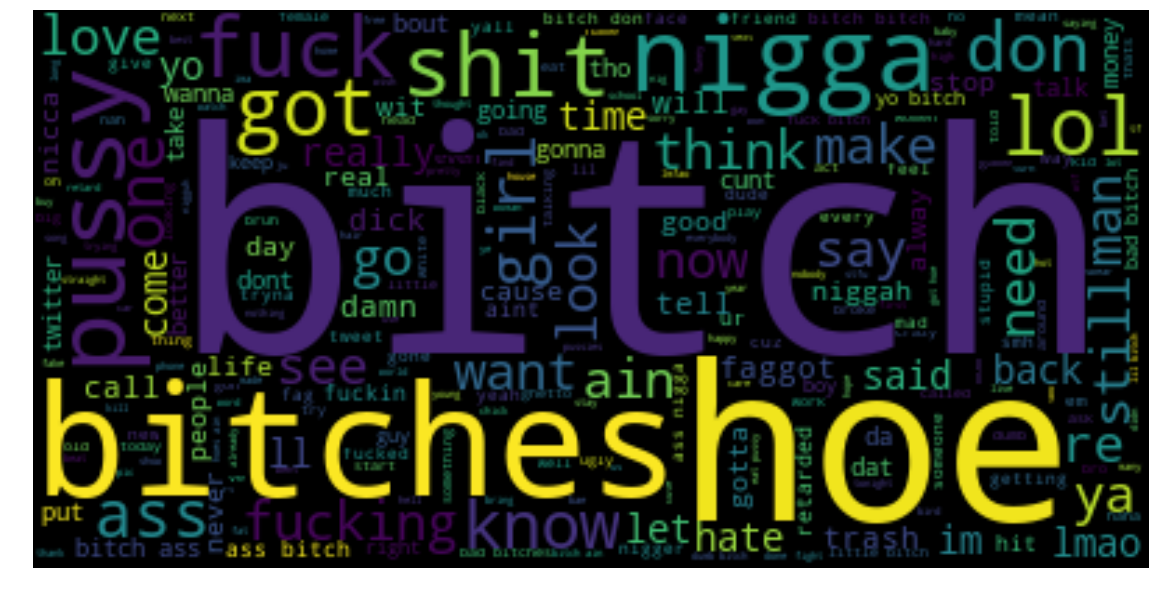

In [73]:
# Create and generate a word cloud image:
# All tweet text
wordcloud1 = WordCloud(max_words=1000).generate(' '.join(hate_speech.text))
# Hateful tweet text
wordcloud2 = WordCloud(max_words=1000).generate(' '.join(hate_speech[hate_speech['class']==0].text))
# Offensive tweet text
wordcloud3 = WordCloud(max_words=1000).generate(' '.join(hate_speech[hate_speech['class']==1].text))
# Neutral tweet text
wordcloud4 = WordCloud(max_words=1000).generate(' '.join(hate_speech[hate_speech['class']==2].text))

# Display the generated image:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('./images_and_presentation/wordcloud_offensive.png', format='png')
plt.show()

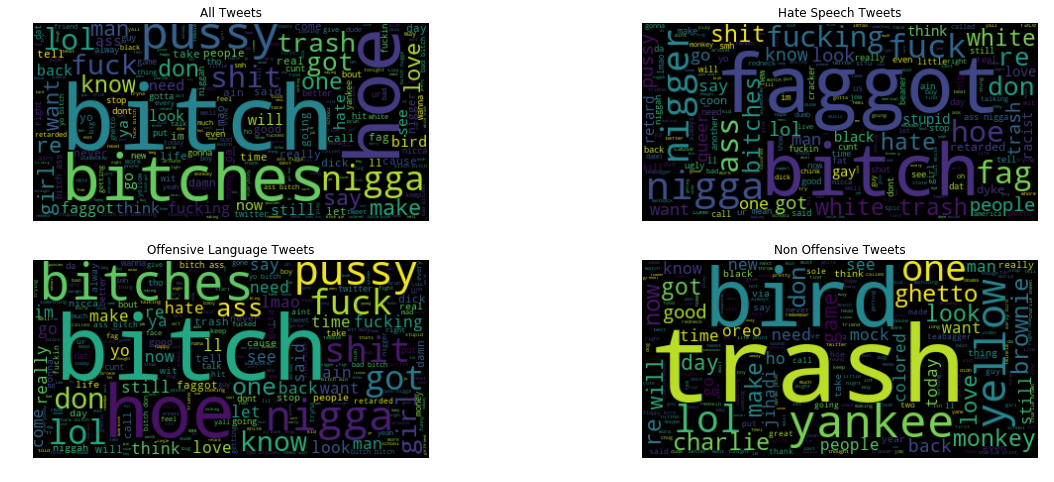

In [72]:
plt.figure(figsize=[20,8])

# Top-left: all words
ax1 = plt.subplot(221)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('All Tweets')

# Top-right: tweets labeled as hate speech
ax2 = plt.subplot(222)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Hate Speech Tweets')

# Bottom-left: tweets labeled as offensive
ax3 =plt.subplot(223)
ax3.imshow(wordcloud3, interpolation='bilinear')
ax3.axis('off')
ax3.set_title('Offensive Language Tweets')

# Bottom-right: tweets labeled as neither offensive nor hate speech
ax4 = plt.subplot(224)
ax4.imshow(wordcloud4, interpolation='bilinear')
ax4.axis('off')
ax4.set_title('Non Offensive Tweets')

plt.axis('off')
plt.savefig('./images_and_presentation/wordcloud_subplots.png', format='png')
plt.show()